# Using Watson Explorer for Sentiment Analysis

This notebook shows you how to use Watson Explorer from DSX Local to analyze unstructured content to perform sentiment analysis.

The data sets for this notebook are real world data from the Airbnb guest reviews of their lodging experience. You'll learn the basic steps to analyze the unstructured data through Watson Explorer and narrow the focus on your unstructured data quickly. In the process you will use Python and WEX, and create sentiment heatmaps.

## Table of contents
This notebook contains the followiong main sections:

- [Prepare the environment](#prepare_environment)
- [Load data](#load_data)
- [Create a Dataset](#create_dataset)
- [Add documents to the Dataset](#add_documents)
- [Locate Part-of-Speech and Sentiment enrichments](#locate_enrichment)
- [Create a collection](#create_collection)
- [Analyze positive targets](#analyze_positive_target)
- [Summary](#summary)

<a id='prepare_environment'></a>
## Prepare the environment
To access Watson Explorer from the notebook, import Watson Explorer Python libraries and specify the endpoint and access information to your Watson Explorer deployment with the following code sample.

In [1]:
import ibmwex

import urllib3
urllib3.disable_warnings()

In [2]:
# Specify the endpoint and access information
configuration = ibmwex.Configuration()
configuration.host = 'https://WEX-RELEASE-NAME-ibm-wex-prod-ui.NAMESPACE:30443'
configuration.username = 'admin'
configuration.password = 'admin'
configuration.verify_ssl = False

# Create a client instance
api_client = ibmwex.ApiClient()

<a id='load_data'></a>
## Load data
The Airbnb reviews for Boston data set can be obtained from [Inside Airbnb](http://insideairbnb.com/about.html).

To get your access key link and load this data set:
1. Find the data set and obtain an access key link:
    1. On the Data Science Experience home page, search for "airbnb".
    1. Click the card with the title [Airbnb Data for Analytics: Boston Reviews](https://datascience.ibm.com/exchange/public/entry/view/107ab470f90be9a4815791d8ec8c2a9e).
    1. Click the link button.
    1. Hover above the link button next to the access key to display the link.
    1. Double-click the link to select it, copy the link, and click **Close**.
    1. Insert the access key link and run the cell to load the data:
    1. In the cell below, replace the **LINK-TO-DATA** string in the `read_csv()` method with the link.
    1. To verify functionality, and see how to load data, run the following cell to import the pandas and numpy libraries, rename and load five columns of the data into the DataFrame, and show the first five rows of guest review data.

In [3]:
import pandas as pd
import numpy as np

# Guest reviews
reviews = pd.read_csv("LINK-TO-DATA", usecols=['id','date','reviewer_name','comments','host_name'])
reviews.columns=['id','date','reviewer','comments','host']
reviews[0:5]

,id,date,reviewer,comments,host
0,19454962,2014-09-13,Jorji,What a fantastic place to stay during our week...,Carlos And Cheryl
1,30021361,2015-04-16,David,Great location and apartment. We would definit...,Carlos And Cheryl
2,31423904,2015-05-05,Theresa,The apartment was neat and clean and accuratel...,Carlos And Cheryl
3,31933451,2015-05-12,Neema,I absolutely loved the location of the apartme...,Carlos And Cheryl
4,34269995,2015-06-07,Aine,My family and I stayed in Boston in June 2015....,Carlos And Cheryl


<a id='create_dataset'></a>
## Create a Dataset
A Dataset is a container where documents are stored for analysis. You can use crawlers and importers to import your data into the Dataset. Once your data is loaded into the Dataset, you can associate it to a Collection and then begin analysis.

The following python code creates a Dataset named 'Airbnb Data : Boston Reviews' with the four fields of date, reviewer, host, and comments:
* `date` : Review date
* `reviewer` : Reviewer name
* `host` : Host name
* `comments` : Review comments

In [4]:
# Create a Dataset
api_datasets = ibmwex.DatasetApi(api_client)
dataset = ibmwex.Dataset()
dataset.name = 'Airbnb Data : Boston Reviews'
dataset.fields = [ibmwex.Field(name='date', type='Date'), ibmwex.Field(name='reviewer', type='String'), ibmwex.Field(name='comments', type='String'), ibmwex.Field(name='host', type='String')]
dataset = api_datasets.create(dataset)

print(dataset.name)

Airbnb Data : Boston Reviews


<a id='add_documents'></a>
## Add documents to the Dataset
In this step, you will use REST API to push data directly into the Dataset. For illustrative purposes, the following python code adds the first 1000 documents of Airnbn review data to the Dataset created in the previous step.

In [5]:
# Add documents
documents = []
for review in reviews[0:1000].fillna({'reviewer':'','comments':'','host':''}).itertuples(index=False):
    document = ibmwex.Document(id=str(review.id), fields={'date':review.date, 'reviewer':review.reviewer, 'comments':review.comments, 'host':review.host}, tag='airbnb_data/boston_reviews')
    documents.append(document)
    
dataset = api_datasets.add_document(dataset.id, documents)

print(dataset.name)

Airbnb Data : Boston Reviews


<a id='locate_enrichment'></a>
## Locate Part-of-Speech and Sentiment enrichments
The next step in performing sentiment analysis will be to analyze the `comments` field and extract linguistic attributes and sentiment expressions. Use the WEX library api's as demonstrated in the python code below to extract words, phrases, and sentiment expressions, retrieve Part-of-Speech and Sentiment enrichment information.

In [6]:
# Retrieve PoS and Sentiment enrichments
pos = None
sentiment = None
api_enrichments = ibmwex.EnrichmentApi(api_client)
for enrichment in api_enrichments.list().items:
    if enrichment.type == 'pos':
        pos = enrichment
    elif enrichment.type == 'sentiment':
        sentiment = enrichment

print(pos.name)
print(sentiment.name)

Part of Speech
Sentiment Analysis


<a id='create_collection'></a>
## Create a collection
A collection is defined as a source dataset and set of enrichments to be applied to the dataset. The documents in the source dataset are enriched through natural langauge processing known as enrichments.

In this step, you will apply Part-of-Speech and Sentiment enrichments to the `comments` field to extract reviewer sentiment expressions about hosts. The following python code creates a collection named 'Airbnb Data : Boston Reviews' with Part-of-Speech and Sentiment enrichments.

In [7]:
api_collections = ibmwex.CollectionApi(api_client)
collection = ibmwex.Collection()
# Collection name
collection.name = 'Airbnb Data : Boston Reviews'
# Link the dataset
collection.datasets = [dataset.id]
# Link PoS and Sentiment enrichments
collection.enrichments = [pos.id, sentiment.id]
# Use the comment field as document body
collection.enrich_field_groups = [ibmwex.EnrichFieldGroup(enrichments=[pos.id, sentiment.id], fields=['comments'])]
collection.tags = {'defaultBodyFieldId':'comments'}
# Define facets tree
collection.category = pos.category
collection.category.children.extend(sentiment.category.children)
# Create a collection
collection = api_collections.create(collection)

print(collection.name)

Airbnb Data : Boston Reviews


Since indexing is not instantaneous, the following code will wait until the timeout value of 10 minutes for the index creation to complete. 

In [8]:
import time

def wait_collection(api_collections, id, timeout_secs=600, period_secs=10):
    mustend = time.time() + timeout_secs
    while (time.time() < mustend):
        completed = True
        status = api_collections.status(id).docproc
        completed = status.completed
        if completed: return True

        time.sleep(period_secs)
    print("Time out")
    return False


print('Wait until indexing is finished...')
wait_collection(api_collections, collection.id)

Wait until indexing is finished...


True

<a id='analyze_positive_target'></a>
## Analyze positive targets

The following code uses the collection that has been created so far to generate and display a positive target facet pair heatmap.

Populating the interactive namespace from numpy and matplotlib


[Text(69,0.5,'Host'), Text(0.5,69,'Positive Target')]

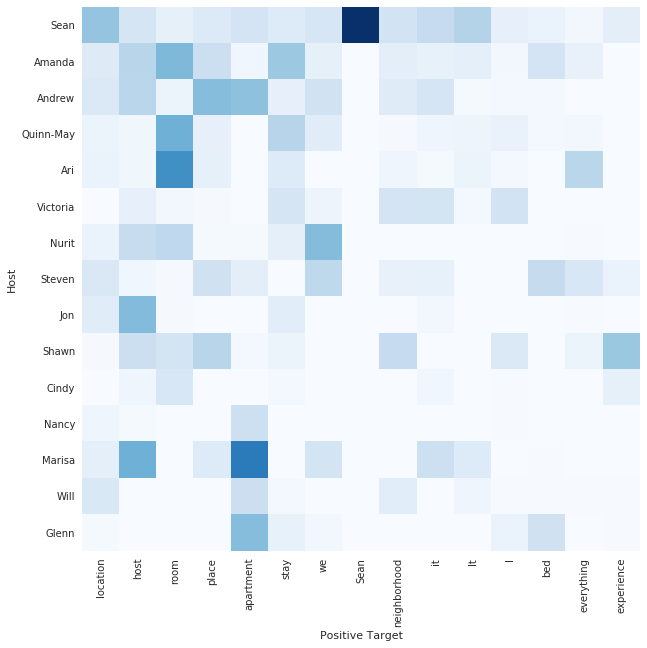

In [9]:
x_dim = 'host'
x_label = 'Host'
y_dim = 'annotation._sentiment.target.positive'
y_label = 'Positive Target'

api_exploration = ibmwex.ExplorationApi(api_client)
results = api_exploration.query(collection.id, '*:*', rows=0, facet='true', 
    facet_field=[x_dim,y_dim], facet_stats='pairs', facet_limit=15)

fs = results.facet_stats

x_labels = list(map(lambda i: i['id'], fs.dims[x_dim]))
y_labels = list(map(lambda i: i['id'], fs.dims[y_dim]))
correlation_matrix = list(
    map(lambda  x : list(map(lambda y : y['correlation'], x)),
        list(map(lambda x : x[y_dim], fs.stats['pairs'][x_dim]))
    )
)

%pylab inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

f, ax = plt.subplots(1, 1, figsize=(10,10))
sns.heatmap(correlation_matrix, xticklabels=y_labels, yticklabels=x_labels, cbar=False, cmap='Blues')
ax.set(xlabel=y_label, ylabel=x_label)

<a id='summary'></a>
## Summary

In this notebook you have learned how to use Watson Explorer from DSX Local to analyze unstructured content to perform sentiment analysis using data sets for that are directly obtained real world data from the Airbnb's guest reviews from their lodging experience. You learned the basic steps to analyze the unstructured data through the Watson Explorer and narrow the focus on your unstructured data using python, python and WEX libraries, and create sentiment heatmaps.